In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

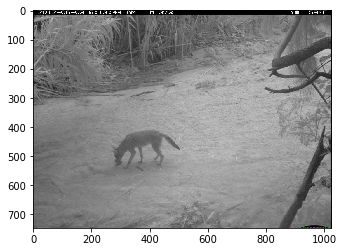

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
# works well
img = get_image('../../../../data/wildcam_subset_sample/train_46/coyote/59817c02-23d2-11e8-a6a3-ec086b02610b.jpg')
#img = get_image('../../../../data/wildcam_subset_sample/train_46/coyote/59e77deb-23d2-11e8-a6a3-ec086b02610b.jpg')
plt.imshow(img)

In [4]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [5]:
img_t = get_input_tensors(img)
type(img_t)

torch.Tensor

In [6]:
img_t.shape

torch.Size([1, 3, 224, 224])

In [7]:
img_numpy = img_t[0,:].numpy().transpose((1, 2, 0))

Plotting the numpy image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


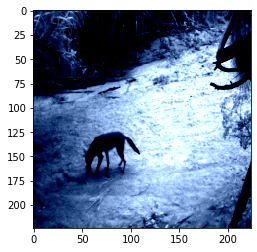

In [8]:
plt.imshow(img_numpy)

In [9]:
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [10]:
segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4, 
                                        max_dist=200, ratio=0.2, 
                                        random_seed=123)    
segments = segmentation_fn(img_numpy)                                   

In [11]:
segments.shape

(224, 224)

In [12]:
fudged_image = img_numpy.copy()                                             
for x in np.unique(segments):                                       
    fudged_image[segments == x] = (                                 
    np.mean(img_numpy[segments == x][:, 0]),                        
    np.mean(img_numpy[segments == x][:, 1]),                        
    np.mean(img_numpy[segments == x][:, 2]))  

In [13]:
fudged_image.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


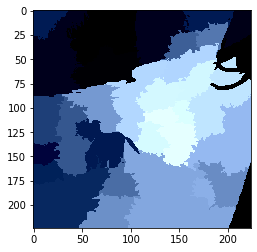

In [14]:
plt.imshow(fudged_image)

In [15]:
import progressbar
from progressbar import ProgressBar
from sklearn.utils import check_random_state 
import copy

In [16]:
import sys 
sys.path.append('..')

from models import get_net
net = get_net("WILDCAM")

model = net(n_classes=2)
print("loading IRM model")
model.load_state_dict(torch.load("../models/wildcam_denoised_121_0.001_40_10000.0_IRM.pth", map_location="cpu"))
model.to("cpu")

loading IRM model


resnet18_extractor(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [17]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [18]:
def batch_predict(images):
    #print("It's in batch")
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    #probs = torch.sigmoid(logits)
    # if you don't pass 2 probs, LIME always classifies all examples in the coyote category
    probs = torch.cat((1-torch.sigmoid(logits), torch.sigmoid(logits)), 1)
    #print(probs.detach().cpu().numpy())
    return probs.detach().cpu().numpy()

In [19]:
test_pred = batch_predict([pill_transf(img), pill_transf(img)])

In [20]:
np.array(pill_transf(img)).shape

(224, 224, 3)

In [21]:
img_numpy.shape

(224, 224, 3)

In [22]:
def data_labels(image, fudged_image, segments, classifier_fn, num_samples, batch_size=10):   
    n_features = np.unique(segments).shape[0]                               
    data = random_state.randint(0, 2, num_samples * n_features).reshape((num_samples, n_features))                                 
    labels = []                                                             
    data[0, :] = 1                                                          
    imgs = []                                                               
    widgets=[progressbar.Percentage(), progressbar.Bar()]                   
    pbar = ProgressBar(max_value=num_samples, widgets=widgets)              
    #pbar = ProgressBar(num_samples)                                        
    sample = 0   
    temp_images = []
    pbar.start()                                                            
    for row in data:         
        temp = copy.deepcopy(image)                                         
        zeros = np.where(row == 0)[0]                                       
        mask = np.zeros(segments.shape).astype(bool)                        
        for z in zeros:                                                     
            mask[segments == z] = True                                      
        temp[mask] = fudged_image[mask]                                     
        imgs.append(temp)            
        temp_images.append(temp)            
        if len(imgs) == batch_size: 
            preds = classifier_fn(np.array(imgs))                           
            labels.extend(preds)   
            imgs = []                                                       
        #pbar.currval += 1                                                  
        sample += 1                                                         
        pbar.update(sample)                                                 
    pbar.finish()                                                           
    if len(imgs) > 0:                                                       
        preds = classifier_fn(np.array(imgs))                               
        labels.extend(preds)  
        
    return temp_images, data, np.array(labels)      

In [23]:
random_state = check_random_state(123)
temp, data, labels = data_labels(np.array(pill_transf(img)),
                           fudged_image,
                           segments,
                           batch_predict,
                           1000, 10)

100%|#########################################################################|


In [24]:
data

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 0, 1],
       ...,
       [1, 0, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [25]:
np.unique(segments)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [26]:
labels

array([[0.72236276, 0.2776372 ],
       [0.39594132, 0.6040587 ],
       [0.488689  , 0.511311  ],
       ...,
       [0.60826236, 0.39173764],
       [0.6061178 , 0.39388222],
       [0.5674219 , 0.4325781 ]], dtype=float32)

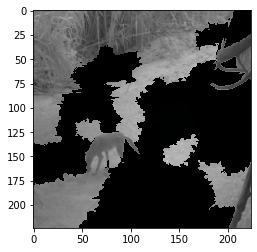

In [27]:
plt.imshow(temp[990]) 

In [28]:
from sklearn import metrics
distances = metrics.pairwise_distances(data,
                                          data[0].reshape(1, -1),
                                          metric='cosine').ravel()  

In [29]:
distances.shape

(1000,)

In [30]:
labels[0]

array([0.72236276, 0.2776372 ], dtype=float32)

In [31]:
top = np.argsort(labels[0])[-1:]
top

array([0])

In [32]:
top

array([0])

In [33]:
labels[:,0]

array([0.72236276, 0.39594132, 0.488689  , 0.42849588, 0.54139006,
       0.5944761 , 0.6261065 , 0.66967803, 0.39244264, 0.5480422 ,
       0.4898286 , 0.7739595 , 0.61742496, 0.58778214, 0.7002416 ,
       0.64966595, 0.5049652 , 0.46907574, 0.7363022 , 0.37826294,
       0.45403963, 0.48985302, 0.7776176 , 0.31595862, 0.7058573 ,
       0.47861224, 0.48373336, 0.6845865 , 0.3446334 , 0.45871872,
       0.6219635 , 0.768168  , 0.58259904, 0.5325525 , 0.5880771 ,
       0.4176129 , 0.70930827, 0.5288161 , 0.64223945, 0.44615805,
       0.50238127, 0.4870186 , 0.513103  , 0.49805593, 0.38426983,
       0.57894975, 0.40814275, 0.4702912 , 0.3984182 , 0.6325669 ,
       0.4986893 , 0.4528216 , 0.44905305, 0.5751046 , 0.6622947 ,
       0.67257494, 0.47915536, 0.5094477 , 0.46901184, 0.40608096,
       0.55700594, 0.32621026, 0.5134584 , 0.49730533, 0.48601824,
       0.54213333, 0.63945955, 0.65103257, 0.52240133, 0.4745295 ,
       0.50933844, 0.46478075, 0.5924798 , 0.45704544, 0.68051

In [34]:
from functools import partial  

kernel_width = float(0.25)                                      
def kernel(d, kernel_width):                                        
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))                                                                                            
kernel_fn = partial(kernel, kernel_width=kernel_width)   

In [35]:
weights = kernel_fn(distances)

In [36]:
weights

array([1.        , 0.36590639, 0.54964003, 0.63988628, 0.63988628,
       0.23953341, 0.72453367, 0.54964003, 0.7638468 , 0.59526502,
       0.3219503 , 0.86623977, 0.36590639, 0.3219503 , 0.68310033,
       0.45711081, 0.68310033, 0.54964003, 0.41111229, 0.59526502,
       0.45711081, 0.27968663, 0.50343962, 0.7638468 , 0.50343962,
       0.50343962, 0.63988628, 0.63988628, 0.68310033, 0.72453367,
       0.54964003, 0.54964003, 0.63988628, 0.54964003, 0.50343962,
       0.41111229, 0.36590639, 0.50343962, 0.50343962, 0.50343962,
       0.27968663, 0.45711081, 0.54964003, 0.72453367, 0.7638468 ,
       0.36590639, 0.45711081, 0.23953341, 0.41111229, 0.54964003,
       0.45711081, 0.45711081, 0.36590639, 0.41111229, 0.54964003,
       0.72453367, 0.59526502, 0.8007374 , 0.36590639, 0.41111229,
       0.50343962, 0.54964003, 0.41111229, 0.27968663, 0.54964003,
       0.36590639, 0.54964003, 0.45711081, 0.41111229, 0.50343962,
       0.36590639, 0.45711081, 0.36590639, 0.41111229, 0.63988

In [37]:
segments[0]

array([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2])

In [38]:
sample = copy.deepcopy(np.array(pill_transf(img)))

In [39]:
sample.shape

(224, 224, 3)

In [40]:
mask = np.zeros(segments.shape).astype(bool)

In [41]:
mask[segments == 23] = True

In [42]:
sample[mask] = fudged_image[mask]

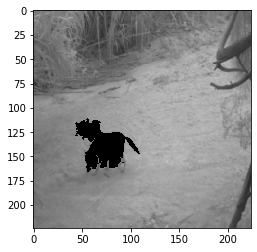

In [43]:
plt.imshow(sample) 

In [44]:
round(np.unique(segments).shape[0]/4)

9

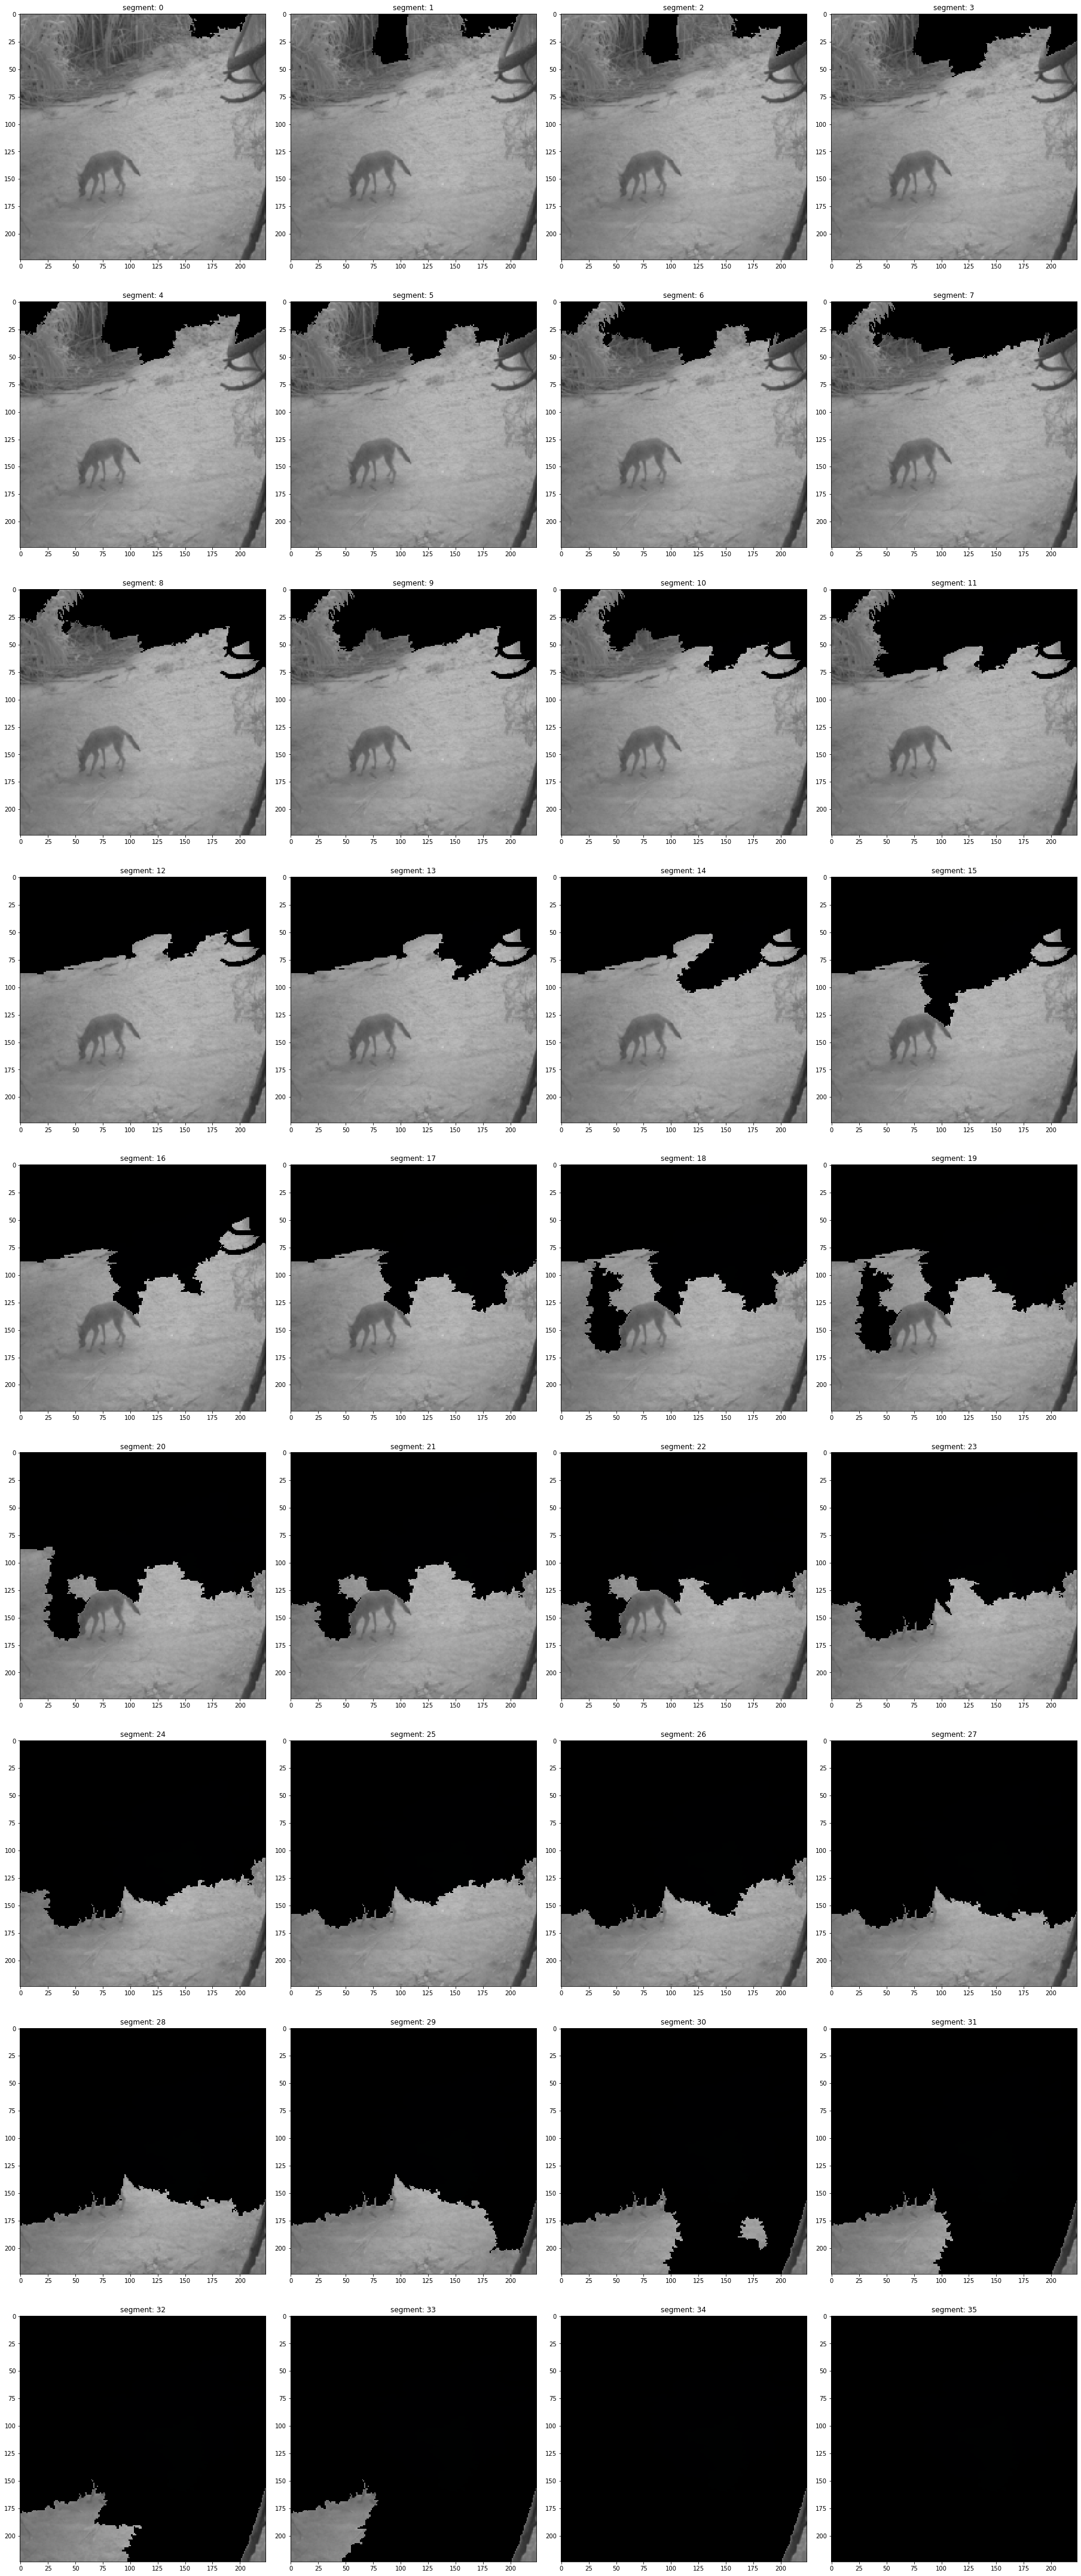

In [51]:
import matplotlib.gridspec as gridspec

mask = np.zeros(segments.shape).astype(bool)
sample = copy.deepcopy(np.array(pill_transf(img)))

fig = plt.figure(constrained_layout=True, figsize=(25, 60))
spec = gridspec.GridSpec(ncols=4, nrows=round(np.unique(segments).shape[0]/4), figure=fig)
col = row = 0

for i in range(np.unique(segments).shape[0]):
    #sample = copy.deepcopy(np.array(pill_transf(img)))
    mask[segments == i] = True
    sample[mask] = fudged_image[mask]
    #print(fudged_image[mask])
    #mask[segments == i] = False
    f_ax = fig.add_subplot(spec[row, col])
    f_ax.set_title(f'segment: {i}')
    f_ax.imshow(sample)
    col += 1
    
    if col in (4, 8, 12, 16, 20, 24, 28, 32):
        row += 1
        col = 0